In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars, get_ap_ar_for_train_val
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_model_from_setup
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders
from models.detectors.rcnn import XAMIRoIHeads
from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from models.dynamic_loss import DynamicWeightedLoss
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])


common_args = {
    "use_custom_model": True,
    "use_early_stop_model": True,
    "best_ar_val_model_path": None,
    "best_ap_val_model_path": None,
    "final_model_path": None,
    "optimiser": "sgd",
    "lr": 1e-3,
    "weight_decay": 0,
    "pretrained": True,
    "record_training_performance": True,
    "dataset_mode": "normal",
    "image_size": 512,
    "batch_size": 4,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": False,
    "clinical_expand_dropout_rate": 0,
    "clinical_conv_dropout_rate": 0,
    "clinical_num_len": 9,
    "fuse_dropout_rate": 0,
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "add",
    "gt_in_train_till": 999,
    "box_head_dropout_rate": 0,
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "clinical_input_channels": 64,
    "representation_size": 64,  # 32
    "clinical_conv_channels": 64,
    "clinical_expand_conv_channels": 64,
    "backbone_out_channels": 64,
}

large_model_args = {
    "mask_hidden_layers": 256,
    "fuse_conv_channels": 256,
    "clinical_input_channels": 256,
    "representation_size": 256,  # 32
    "clinical_conv_channels": 256,
    "clinical_expand_conv_channels": 256,
    "backbone_out_channels": 256,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

resnet_args = {
    "using_fpn": True,
    "backbone": "resnet50",
}

# patience=10, but start with 1e-2.
all_model_setups = [
    ### Old
    # ModelSetup(
    #     name="with_clinical_add_res",
    #     use_clinical=True,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="mobilenet_v3",
    #     optimiser="sgd",
    #     lr=1e-2,
    #     weight_decay=0.001,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     backbone_out_channels=16,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     lr_scheduler="ReduceLROnPlateau",
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=10,
    #     multiStepLR_milestones=[30, 50, 70, 90],
    #     multiStepLR_gamma=0.1,
    #     representation_size=32,
    #     mask_hidden_layers=256,
    #     using_fpn=False,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_input_channels=32,
    #     clinical_num_len=9,
    #     clinical_conv_channels=32,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     box_head_dropout_rate=0,
    #     fuse_depth=4,
    #     fusion_strategy="add",
    #     fusion_residule=True,
    # ),
    ### CXR - Done
    # ModelSetup(
    #     name="CXR",
    #     use_clinical=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="resnet50",
    #     using_fpn=True,
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=256,
    #     backbone_out_channels=16,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     # lr_scheduler="ReduceLROnPlateau",
    #     lr_scheduler=None,
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=10,
    #     reduceLROnPlateau_full_stop=False,
    #     multiStepLR_milestones=[100],
    #     multiStepLR_gamma=0.1,
    #     mask_hidden_layers=256,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_num_len=9,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     box_head_dropout_rate=0,
    #     fuse_depth=4,
    #     fusion_strategy="add",
    #     fusion_residule=False,
    #     clinical_input_channels=64,
    #     representation_size=32, # 32
    #     clinical_conv_channels=256,
    # ),
    ### CXR - Clinical
    ## train a model to see if the validation loss still increase.
    # ModelSetup(
    #     name="CXR_Clinical_fusion1_fusino2",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=True,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    # ),
    ModelSetup(
        name="CXR_Clinical_fusion1",
        use_clinical=True,
        spatialise_clinical=True,
        add_clinical_to_roi_heads=False,
        **mobilenet_args,
        **small_model_args,
        **common_args,
    ),
    ModelSetup(
        name="CXR_Clinical_fusion2",
        use_clinical=True,
        spatialise_clinical=False,
        add_clinical_to_roi_heads=True,
        **mobilenet_args,
        **small_model_args,
        **common_args,
    ),
    # ModelSetup(
    #     name="CXR",
    #     use_clinical=False,
    #     spatialise_clinical=False,
    #     add_clinical_to_roi_heads=False,
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    # ),
    # ModelSetup(
    #     name="CXR_Clinical_roi_heads",
    #     use_clinical=True,
    #     spatialise_clinical=False,
    #     add_clinical_to_roi_heads=True,
    #            use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="resnet50",
    #     using_fpn=True,
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=512,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     # lr_scheduler="ReduceLROnPlateau",
    #     lr_scheduler="ReduceLROnPlateau",
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=999,
    #     reduceLROnPlateau_full_stop=True,
    #     multiStepLR_milestones=[100],
    #     multiStepLR_gamma=0.1,
    #     mask_hidden_layers=256,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_num_len=9,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     fuse_depth=0,
    #     fusion_residule=False,
    #     # if it still have overfitting issue, then we don't need to increase the model size (we should rather to decrease it.)
    #     fusion_strategy="add",
    #     clinical_input_channels=512,
    #     representation_size=256,  # 32
    #     box_head_dropout_rate=0,
    #     clinical_conv_channels=256,
    #     clinical_expand_conv_channels=256,
    #     backbone_out_channels=16,
    #     gt_in_train_till=0,
    # ),
    # ModelSetup(
    #     name="CXR_Clinical_spatialisation",
    #     use_clinical=True,
    #     spatialise_clinical=True,
    #     add_clinical_to_roi_heads=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="resnet50",
    #     using_fpn=True,
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=512,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     # lr_scheduler="ReduceLROnPlateau",
    #     lr_scheduler="ReduceLROnPlateau",
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=999,
    #     reduceLROnPlateau_full_stop=True,
    #     multiStepLR_milestones=[100],
    #     multiStepLR_gamma=0.1,
    #     mask_hidden_layers=256,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_num_len=9,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     fuse_depth=0,
    #     fusion_residule=False,
    #     # if it still have overfitting issue, then we don't need to increase the model size (we should rather to decrease it.)
    #     fusion_strategy="add",
    #     clinical_input_channels=512,
    #     representation_size=256,  # 32
    #     box_head_dropout_rate=0,
    #     clinical_conv_channels=256,
    #     clinical_expand_conv_channels=256,
    #     backbone_out_channels=16,
    #     gt_in_train_till=0,16,
    #     gt_in_train_till=999,
    # ),
    # ModelSetup(
    #     name="CXR",
    #     use_clinical=False,
    #     spatialise_clinical=False,
    #     add_clinical_to_roi_heads=False,
    #     use_custom_model=True,
    #     use_early_stop_model=True,
    #     best_ar_val_model_path=None,
    #     best_ap_val_model_path=None,
    #     final_model_path=None,
    #     backbone="resnet50",
    #     using_fpn=True,
    #     optimiser="sgd",
    #     lr=1e-3,
    #     # lr=1e-4,
    #     # weight_decay=0.001,
    #     weight_decay=0,
    #     pretrained=True,
    #     record_training_performance=True,
    #     dataset_mode="unified",
    #     image_size=512,
    #     batch_size=4,
    #     warmup_epochs=0,
    #     # lr_scheduler="ReduceLROnPlateau",
    #     lr_scheduler="ReduceLROnPlateau",
    #     reduceLROnPlateau_factor=0.1,
    #     reduceLROnPlateau_patience=999,
    #     reduceLROnPlateau_full_stop=True,
    #     multiStepLR_milestones=[100],
    #     multiStepLR_gamma=0.1,
    #     mask_hidden_layers=256,
    #     use_mask=False,
    #     clinical_expand_dropout_rate=0,
    #     clinical_conv_dropout_rate=0,
    #     clinical_num_len=9,
    #     fuse_conv_channels=32,
    #     fuse_dropout_rate=0,
    #     fuse_depth=0,
    #     fusion_residule=False,
    #     # if it still have overfitting issue, then we don't need to increase the model size (we should rather to decrease it.)
    #     fusion_strategy="add",
    #     clinical_input_channels=512,
    #     representation_size=256,  # 32
    #     box_head_dropout_rate=0,
    #     clinical_conv_channels=256,
    #     clinical_expand_conv_channels=256,
    #     backbone_out_channels=16,
    #     gt_in_train_till=0,
    # ),
]


### [TODO] ###

# [ ] - enlarge the size of the image, more input data may mean a better generalization we need.
# [ ]


In [4]:
# if train_info.epoch > model_setup.gt_in_train_till:
# model.roi_heads.use_gt_in_train 

In [5]:
num_epochs = 100
train_infos = []

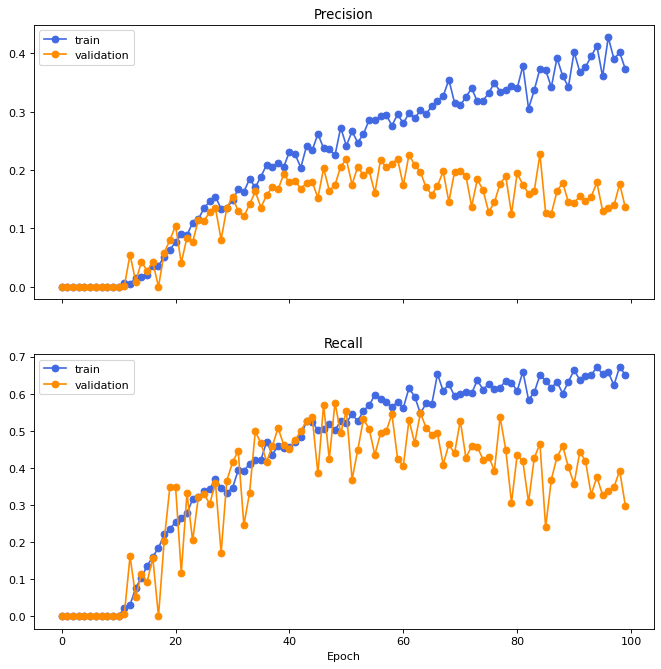

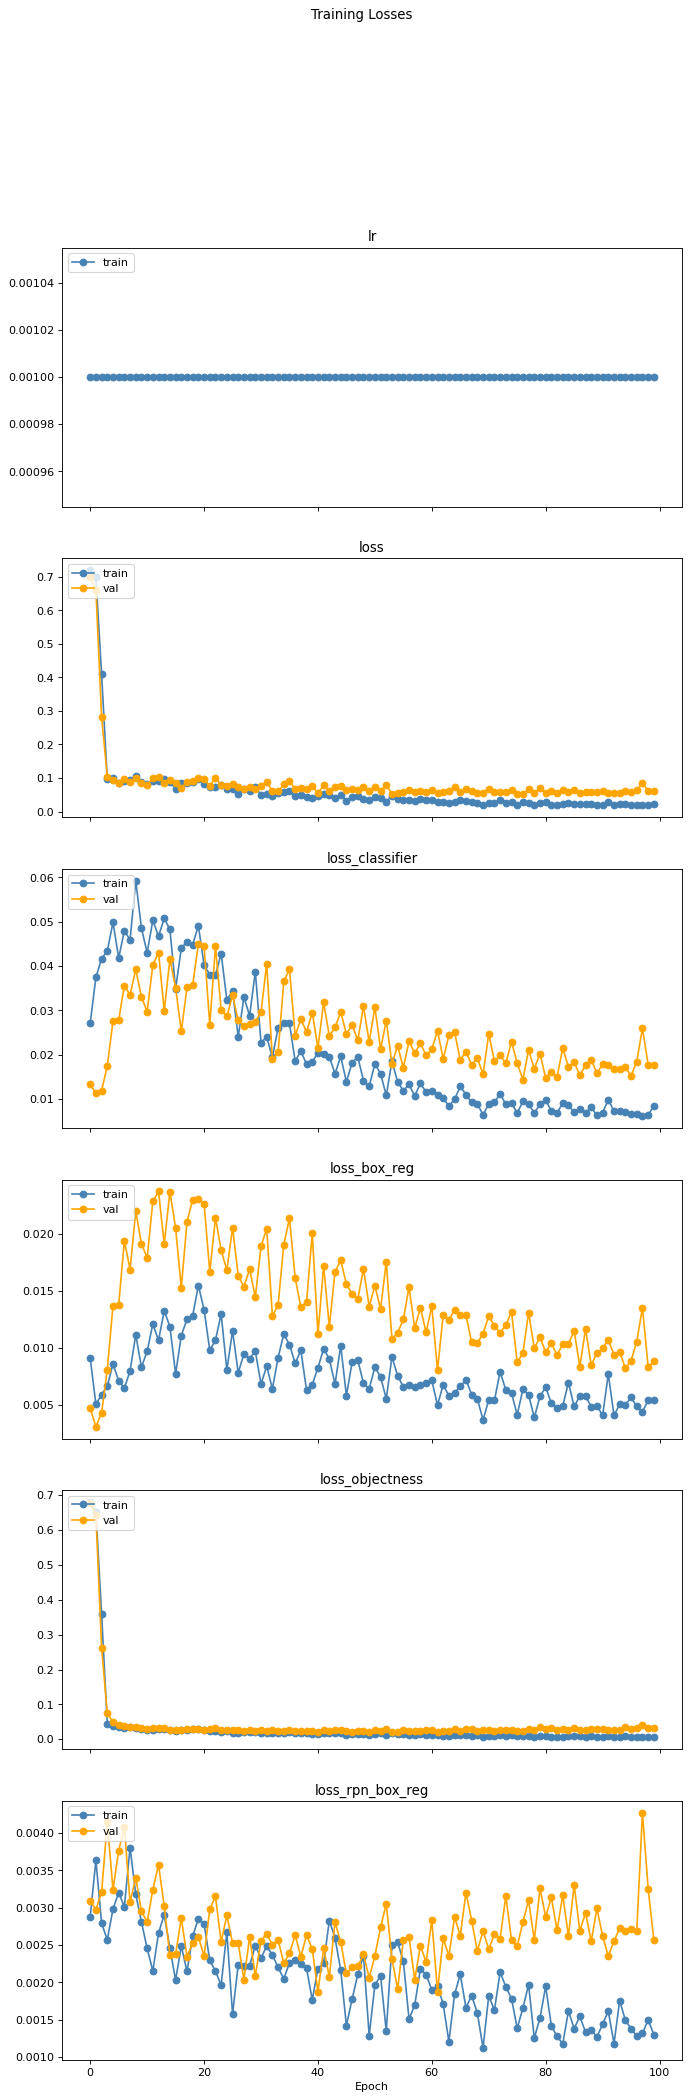

====================| Epoch [100] Done | It has took [172.40] min, Avg time: [103.44] sec/epoch | Estimate time for [100] epochs: [172.40] min | Epoch took [99] sec | Patience [23] |====================
====================| Training Done, start testing! | [100] Epochs Training time: [10344] seconds, Avg time / Epoch: [103.44] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_4654_ap_0_2274_test_ar_0_4886_ap_0_2157_epoch85_WithClincal_05-25-2022 06-02-35_CXR_Clinical_fusion2]====================
====================Best AR validation model has been saved to: [val_ar_0_5760_ap_0_1744_test_ar_0_5622_ap_0_1990_epoch49_WithClincal_05-25-2022 05-01-33_CXR_Clinical_fusion2]====================
Evaluation:  [ 0/26]  eta: 0:00:17  loss: 0.0166 (0.0166)  loss_classifier: 0.0110 (0.0110)  loss_box_reg: 0.0025 (0.0025)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0004 (0.0004)  model_time: 0.0390 (0.0390)  evaluator_time: 0.0010 (0.001

In [6]:
for model_setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.to(device)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )


    # dynamic_loss_weight = None
    dynamic_loss_weight = DynamicWeightedLoss()
    dynamic_loss_weight.to(device)
    print_params_setup(model)


    params = [p for p in model.parameters() if p.requires_grad]
    if dynamic_loss_weight:
        params += [p for p in dynamic_loss_weight.parameters() if p.requires_grad]

    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(params, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_data.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_data.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        ### update the learning rate

        val_loss = train_info.val_data[-1]["loss"]

        if train_info.epoch > model_setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if model_setup.reduceLROnPlateau_full_stop and lr_scheduler.num_bad_epochs >= model_setup.reduceLROnPlateau_patience:
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs") :
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(
           print_str
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )

    val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ar,        last_val_ap=val_ap,
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
    )

    train_infos.append(train_info)

In [7]:
### A really good one using both.

# ====================| Epoch [43] Done | It has took [115.78] min, Avg time: [161.56] sec/epoch | Estimate time for [100] epochs: [269.26] min | Epoch took [152] sec | Patience [28] |====================
# ====================Training model: [CXR_Clinical_roi_heads_spatialisation]====================
# ========================================For Training [CXR_Clinical_roi_heads_spatialisation]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR_Clinical_roi_heads_spatialisation', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=512, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=[100], multiStepLR_gamma=0.1, representation_size=256, mask_hidden_layers=256, using_fpn=True, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=512, clinical_expand_conv_channels=256, clinical_num_len=9, clinical_conv_channels=256, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=0, spatialise_clinical=True, add_clinical_to_roi_heads=True, fusion_strategy='add', fusion_residule=False, gt_in_train_till=0)
# ====================================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_5280_ap_0_3254_test_ar_0_4181_ap_0_2684_epoch39_WithClincal_05-23-2022 01-39-40_CXR_Clinical_roi_heads_spatialisation]
# Best AR validation model has been saved to: [val_ar_0_5792_ap_0_3198_test_ar_0_4822_ap_0_2286_epoch41_WithClincal_05-23-2022 01-45-05_CXR_Clinical_roi_heads_spatialisation]
# The final model has been saved to: [val_ar_0_5792_ap_0_3198_test_ar_0_4822_ap_0_2286_epoch41_WithClincal_05-23-2022 01-45-05_CXR_Clinical_roi_heads_spatialisation]

# ====================================================================================================================================

========================================For Training [CXR_Clinical_fusion1]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR_Clinical_fusion1', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='normal', image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=64, clinical_expand_conv_channels=64, clinical_num_len=9, clinical_conv_channels=64, fuse_conv_channels=64, fuse_dropout_rate=0, box

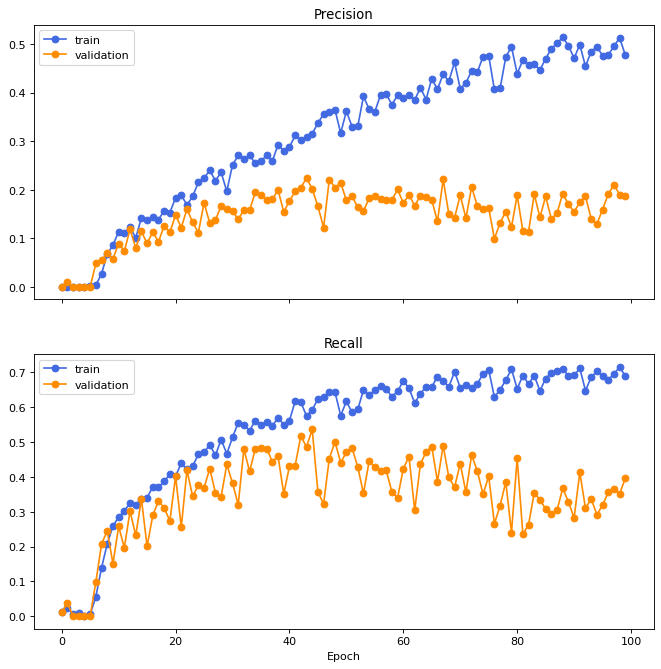

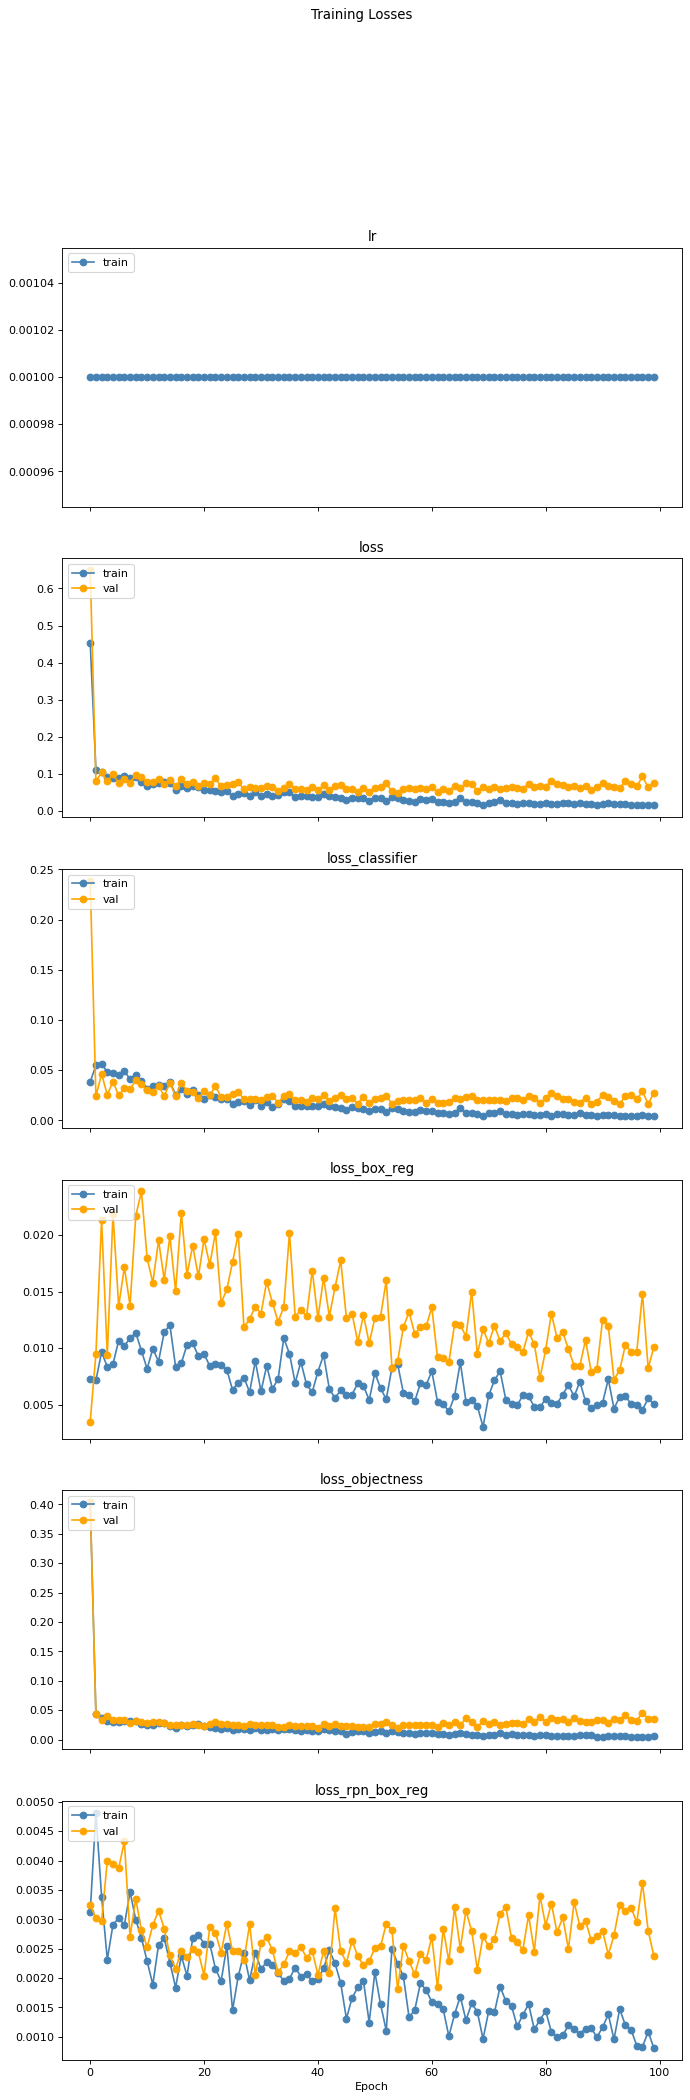

========================================For Training [CXR_Clinical_fusion2]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='CXR_Clinical_fusion2', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=0, pretrained=True, record_training_performance=True, dataset_mode='normal', image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=64, clinical_expand_conv_channels=64, clinical_num_len=9, clinical_conv_channels=64, fuse_conv_channels=64, fuse_dropout_rate=0, box

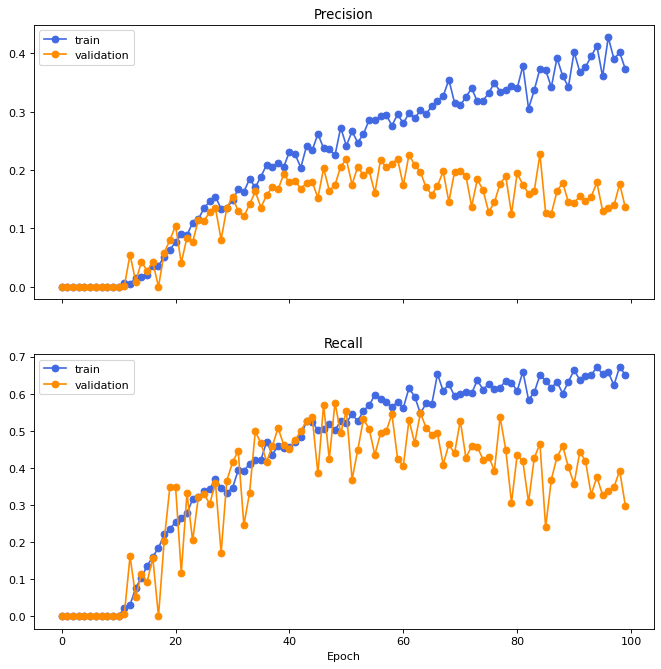

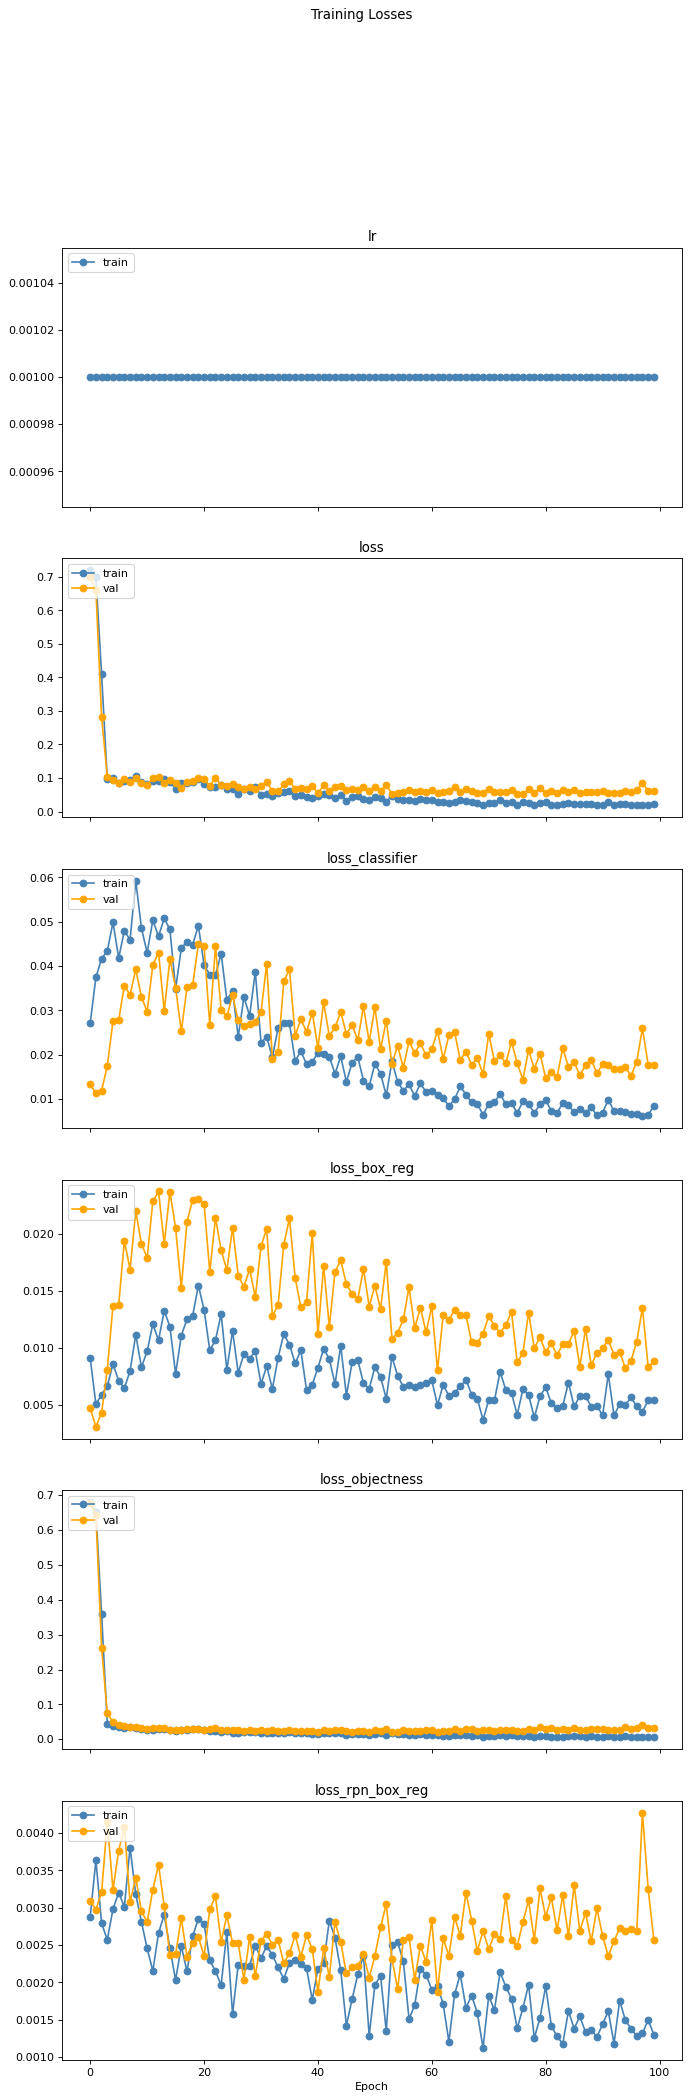

In [8]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
    plot_losses(train_info.train_data, train_info.val_data)



In [9]:
# for k, v in dynamic_loss_weight.params.items():
#     print(f"{k}:{v}")

In [10]:
# [model]: 4,969,055
# [model.backbone]: 1,009,968
# [model.rpn]: 3,595
# [model.roi_heads]: 3,955,492
# [model.roi_heads.mask_head]: 1,807,360
# [model.roi_heads.box_head]: 1,853,440
# [model.roi_heads.box_head.fc6]: 803,840
# [model.roi_heads.box_head.fc7]: 1,049,600
# [model.roi_heads.box_predictor]: 30,750


In [11]:
# resnet18 -

# mobilenet - 37,301,135
# resnet18 - 30,918,643


In [12]:
# val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

# train_info = end_train(
#     train_info=train_info,
#     model=model,
#     optim=optimizer,
#     eval_params_dict=eval_params_dict,
#     last_val_ar=val_ar,
#     last_val_ap=val_ap,
#     test_dataloader=test_dataloader,
#     device=device,   
#     test_coco=test_coco,
#     iou_types=iou_types,
#     score_thres=None,
# )

# print(train_info)

In [13]:
# print(train_info)
# model_setup = train_info.model_setup
# model = create_model_from_setup(
#     labels_cols,
#     model_setup,
#     rpn_nms_thresh=0.3,
#     box_detections_per_img=10,
#     box_nms_thresh=0.2,
#     rpn_score_thresh=0.0,
#     box_score_thresh=0.05,
# )
# print_params_setup(model)
# plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
# plot_losses(train_info.train_data, train_info.val_data)